## SVD 
---
Surprise algorithm: SVD(biased=False, n_epochs = 100)

Hyperparameter: 
1. Threshold when do the recommendation
2. n_factors in SVD 

Things to do:
1. Calculate test loss
2. Do the recommendations (done)
3. Calculate precision, recall

In [1]:
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation

In [2]:
random_dict = preprocess.create_random_subset_paper_paper_data(debug=True)
# all_dict = preprocess.create_paper_paper_dict(debug=True)
traindict, testdict = preprocess.create_train_test_dic(random_dict)

trainset = preprocess.create_surprise_paper_paper_data(traindict).build_full_trainset()
testset  = preprocess.create_surprise_paper_paper_data(testdict).build_full_trainset().build_testset()

# Use surprise train, test split
# data = preprocess.create_surprise_paper_paper_data(random_dict)
# trainset, testset = train_test_split(data, test_size=.25)

In [3]:
testset[0]

('9753c508-20e1-4f9b-baf4-f0c49008dcbc',
 'd578fe46-9b3d-4425-8e2b-a2aac2170b06',
 2.0)

In [4]:
algo = SVD(biased=False, n_epochs = 100)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [5]:
df[0:10]

,uid,iid,rui,est,details
0,9753c508-20e1-4f9b-baf4-f0c49008dcbc,d578fe46-9b3d-4425-8e2b-a2aac2170b06,1.0,-1.324634,{'was_impossible': False}
1,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,5e7b1c2c-baaf-466d-be01-c075002bf1fb,1.0,-1.130830,{'was_impossible': False}
2,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,e8cbffc8-d292-4d4b-ae22-f96c645e4461,1.0,-0.785084,{'was_impossible': False}
3,ed43ebb5-f6c4-4a3e-9ea3-8e5c17de7178,8188df0c-955f-4fef-961d-c67ae2ee3799,1.0,-1.316084,{'was_impossible': False}
4,5d98c64a-c521-41f7-95f9-eb07a4c40196,f967618b-e047-43a9-bea8-44b9e74d708f,1.0,-0.862205,{'was_impossible': False}
5,2ced1d5a-a5ff-4860-99d2-9832b11b1f40,978efa8a-b62a-4e76-a2a1-c3a7af5e1a60,1.0,-1.017178,{'was_impossible': False}
6,c59e69d0-32bb-416c-aed2-3211aa5ceb30,71f4c930-83fe-4cf2-b895-264d716e02b2,1.0,-0.674654,{'was_impossible': False}
7,b2336fd0-40a2-4c1f-9c4b-fcbfd5c68ac4,d35738a8-0c5f-4788-bbcc-ef55a504be78,1.0,-1.001317,{'was_impossible': False}
8,c4161e2c-84c1-4b71-a63a-33230f5ebce9,70f4dcf0-2784-4627-899c-1463988a3f52,1.0,-1.247211,{'was_impossible': False}
9,d9194ae3-7fa8-4c1c-a681-d1bac8050fa7,3662e5bc-d634-43c2-90fe-f18ebd3033f4,1.0,-0.844546,{'was_impossible': False}


In [6]:
# rmse on test set
accuracy.rmse(predictions)

RMSE: 1.9554


1.9553612039928154

### Comments - 
1. All the estimate value are negative in the above table while they should be close to 1.

2. We might not want to use the function provided in surprise since it doesn't take in account of the case when prediction is impossible.

In [7]:
# Visualize train set data
usernum = trainset.n_users
itemnum = trainset.n_items

papermat = sp.dok_matrix((usernum,itemnum), dtype=np.int8)
for i in range(trainset.n_users):
    for paper_id in trainset.ur[i]:
        papermat[i, paper_id[0]] = 1

In [8]:
# Visualize test set data
for j in range(len(testset)):
    uid    = testset[j][0]
    iid    = testset[j][1]
    rating = testset[j][2]
    try:
        iuid = algo.trainset.to_inner_uid(uid)
    except:
        continue
    try:
        iiid = algo.trainset.to_inner_iid(iid)
    except:
        continue
#     print(iuid, iiid)
    papermat[iuid, iiid] = -1

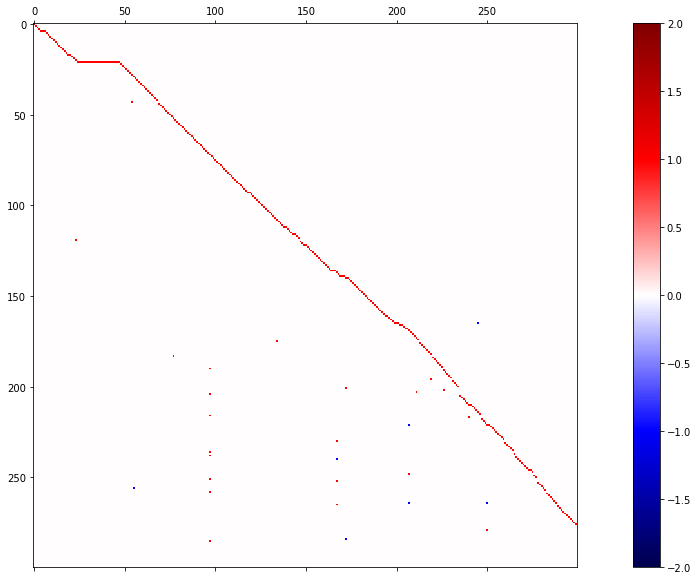

In [9]:
A = papermat.todense()
fig, axes = plt.subplots(figsize=(20, 10))
pos = axes.matshow(A[0:300,0:300], cmap='seismic',vmin=-2., vmax=2.)
fig.colorbar(pos)

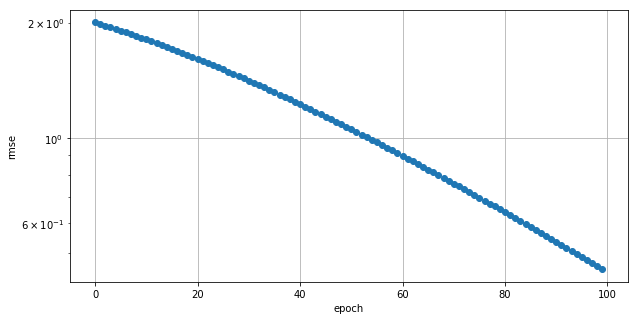

In [10]:
# Comment out following code if not using --
#  https://github.com/MelodyShih/Surprise/tree/1003-project
loss = algo.losshistory
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(range(len(loss)), loss, '--o')
ax.set_xlabel('epoch')
ax.set_ylabel('rmse')
plt.grid(True)

In [11]:
trainestdata = trainset.build_testset()
trainpredictions = algo.test(trainestdata, clip=False)
rmse = accuracy.rmse(trainpredictions)
print(loss[-1])

RMSE: 0.4454
0.453570203267


In [12]:
# Only work for SVD with biased = False
pu = algo.pu
qi = algo.qi

Abar = np.dot(pu, np.transpose(qi))
print(Abar.shape)
Abar = Abar - np.ones(Abar.shape)

(2556, 2300)


-2.79747659879 1.03611209856


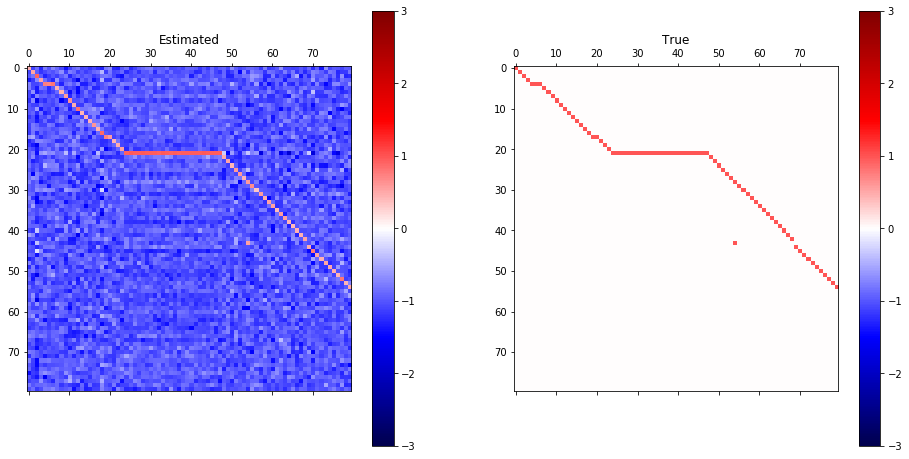

In [13]:
fig, axes = plt.subplots(1, 2)
threshold = -3

minvalue = np.amin(Abar)
maxvalue = np.amax(Abar)
print(minvalue, maxvalue)

mask = Abar[0:80, 0:80] >= threshold
pos = axes[0].matshow(Abar[0:80,0:80] , cmap='seismic',vmin=-3, vmax=3.)
axes[0].set_title('Estimated')
fig.colorbar(pos, ax=axes[0])

pos = axes[1].matshow(A[0:80, 0:80] , cmap='seismic',vmin=-3, vmax=3.)
axes[1].set_title('True')
fig.colorbar(pos, ax=axes[1])

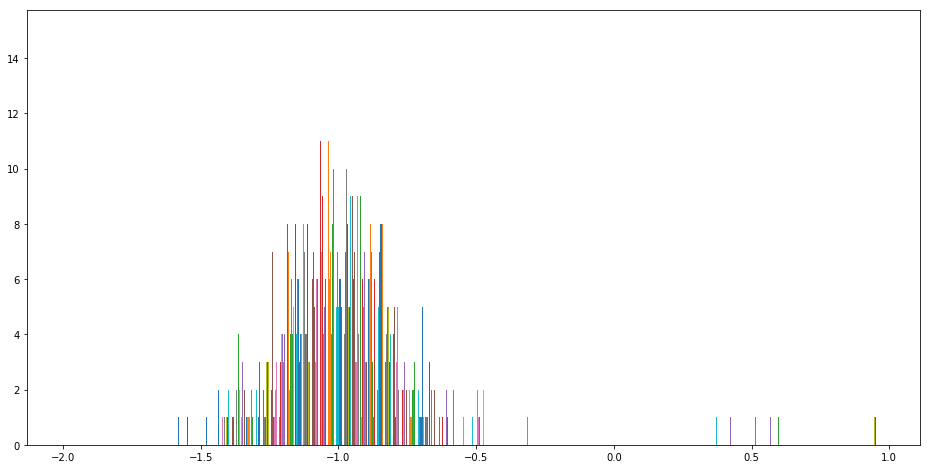

In [14]:
plt.hist(Abar[0:100, 0:100],bins=100)
plt.show()

### Comments - 
From loss and the above graph, SVD fits the training data well.

## Hyperparameter

In [15]:
print(trainset.n_users)
print(trainset.n_items)

2556
2300


### number of factors (n_factors)

In [25]:
factors_to_try = [10,50,100,500, 1000]
rmse_train = np.zeros(len(factors_to_try))
rmse_test = np.zeros(len(factors_to_try))
elapsed_time = np.zeros(len(factors_to_try))
for i in range(len(factors_to_try)):
    nfactors = factors_to_try[i]
    
    t = time.time()
    algo = SVD(biased=False, n_epochs = 500, n_factors = nfactors)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train[i] = accuracy.rmse(trainpredictions)
    rmse_test[i]  = accuracy.rmse(testpredictions)
    print(rmse_train[i], rmse_test[i], 'time = ', elapsed_time[i])

RMSE: 0.0266
RMSE: 2.0355
0.0266468034906 2.0355257043 time =  2.0252199173
RMSE: 0.0241
RMSE: 1.9924
0.0240754415562 1.99240285914 time =  3.68380904198
RMSE: 0.0232
RMSE: 1.9713
0.0231586593925 1.97130172215 time =  5.93326878548
RMSE: 0.0167
RMSE: 1.9996
0.0167380007254 1.9995775631 time =  35.8670778275
RMSE: 0.0134
RMSE: 2.0274
0.0133997454397 2.02741563927 time =  78.5010588169


Text(0,0.5,'seconds')

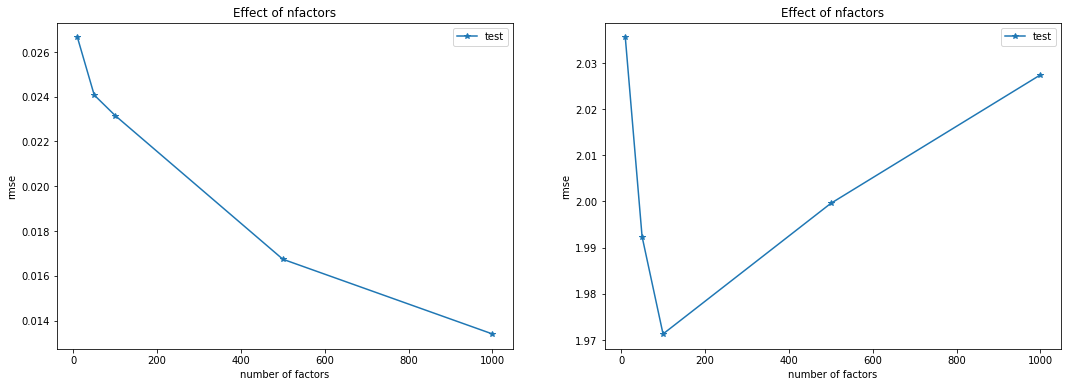

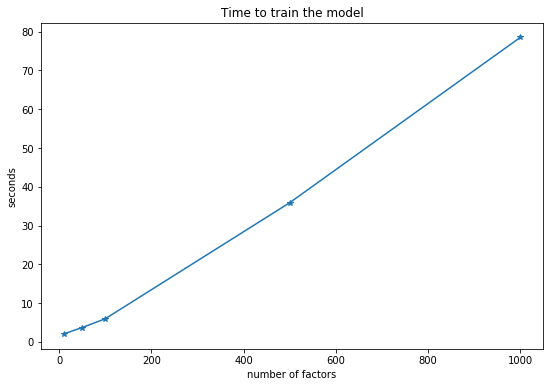

In [26]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].plot(factors_to_try, rmse_train, '-*', label="test")
axes[0].set_title('Effect of nfactors')
axes[0].set_xlabel('number of factors')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].plot(factors_to_try, rmse_test, '-*', label="test")
axes[1].set_title('Effect of nfactors')
axes[1].set_xlabel('number of factors')
axes[1].set_ylabel('rmse')
axes[1].legend()

fig, axes = plt.subplots(figsize=(9,6))
axes.plot(factors_to_try, elapsed_time, '-*')
axes.set_title('Time to train the model')
axes.set_xlabel('number of factors')
axes.set_ylabel('seconds')

### Comments:
Changing the number of factors doens't seem to help us reduce the root mean square error (rmse).

### lambda

In [42]:
nfactors = 50
reg_lambdas = 10**np.linspace(-3,2,6)
rmse_train = np.zeros(len(reg_lambdas))
rmse_test  = np.zeros(len(reg_lambdas))
elapsed_time = np.zeros(len(reg_lambdas))
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    
    t = time.time()
    algo = SVD(biased=False, n_epochs = 500, n_factors = nfactors, reg_all=reg_lambda)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train[i] = accuracy.rmse(trainpredictions)
    rmse_test[i]  = accuracy.rmse(testpredictions)
    print(reg_lambda,rmse_train[i], rmse_test[i], 'time = ', elapsed_time[i])

RMSE: 0.0015
RMSE: 2.0191
0.001 0.00153928454813 2.01912824338 time =  3.93424201012
RMSE: 0.0127
RMSE: 1.9786
0.01 0.0127048651089 1.97856912551 time =  3.54140067101
RMSE: 0.1072
RMSE: 1.9218
0.1 0.107182638138 1.92182242416 time =  3.31841802597
RMSE: 1.0151
RMSE: 1.9056
1.0 1.01507397014 1.90556074495 time =  3.25023293495
RMSE: 2.0000
RMSE: 2.0000
10.0 2.0 2.0 time =  3.18488192558
RMSE: 2.0000
RMSE: 2.0000
100.0 2.0 2.0 time =  3.69409298897


Text(0,0.5,'seconds')

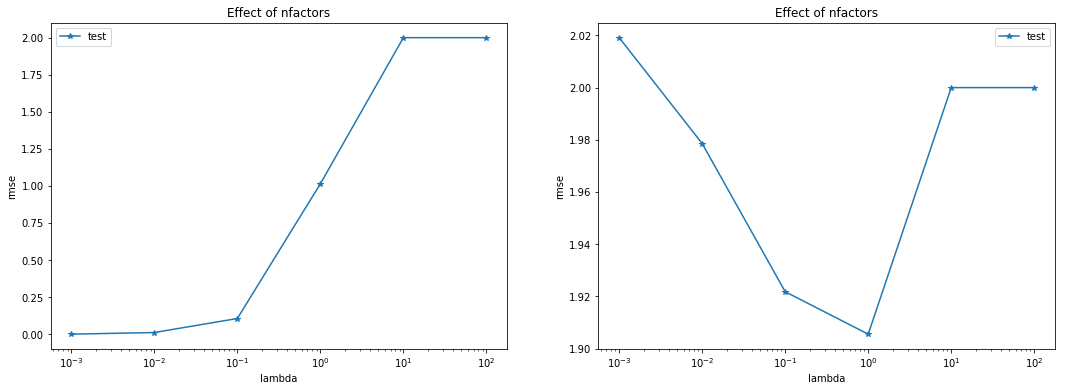

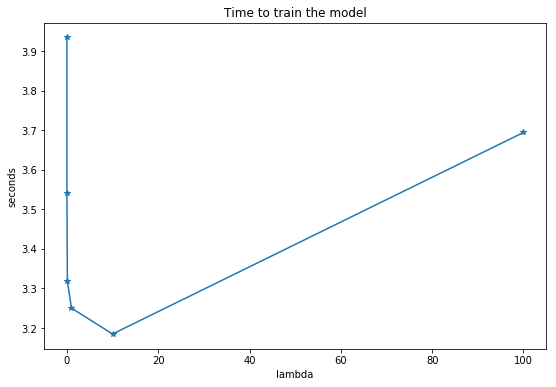

In [43]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].semilogx(reg_lambdas, rmse_train, '-*', label="test")
axes[0].set_title('Effect of nfactors')
axes[0].set_xlabel('lambda')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].semilogx(reg_lambdas, rmse_test, '-*', label="test")
axes[1].set_title('Effect of nfactors')
axes[1].set_xlabel('lambda')
axes[1].set_ylabel('rmse')
axes[1].legend()

fig, axes = plt.subplots(figsize=(9,6))
axes.plot(reg_lambdas, elapsed_time, '-*')
axes.set_title('Time to train the model')
axes.set_xlabel('lambda')
axes.set_ylabel('seconds')

## Recommendation list

In [18]:
# this function can put in surprise
def build_data_for_prediction(self,user_ids):
    """Return a list of ratings that can be used as a testset in the
    :meth:`test() <surprise.prediction_algorithms.algo_base.AlgoBase.test>`
    method.
    """
    alldata = []
    for i in range(len(user_ids)):
        for j in range(self.n_items):
            alldata.append((self.to_raw_uid(i),self.to_raw_iid(j),0))
    return alldata

In [19]:
# build a list to do the recommendation for user_ids
user_ids = [0]
userdata = build_data_for_prediction(trainset, user_ids)

predictions = algo.test(userdata[0:len(user_ids)], clip=False)
rec_list = evaluation.get_items_greater_threshold(predictions, -0.1)

In [20]:
# list of papers that recommend to user_id = 0
rec_list

defaultdict(list,
            {'7497af9d-421d-469a-a592-6a11f57828f9': [('46c32eca-e3d5-4e81-8e7d-f1692c00e4af',
               0.99238576949423352)]})

## Precision and Recall

In [44]:
algo = SVD(biased=False, n_epochs = 500, n_factors = 50, reg_all=1)
algo.fit(trainset)

user_ids = list(testdict.keys())
user_est_true = evaluation.prediction_for_userids(algo, trainset, testdict, user_ids)

In [45]:
thresholds = np.linspace(-3,3,100)
precision = np.zeros(len(thresholds))
recall = np.zeros(len(thresholds))
f1 = np.zeros(len(thresholds))

for t,threshold in enumerate(thresholds):
    precisions, recalls = evaluation.precision_recall_at_k(user_est_true, testdict, k=10, threshold=threshold)
    precision[t] = sum(prec for prec in precisions.values()) / len(precisions)
    recall[t] = sum(rec for rec in recalls.values()) / len(recalls)
    f1[t] = 2*(precision[t]*recall[t])/(precision[t]+recall[t])
#     print(precision_hist[t])

Text(0,0.5,'precision')

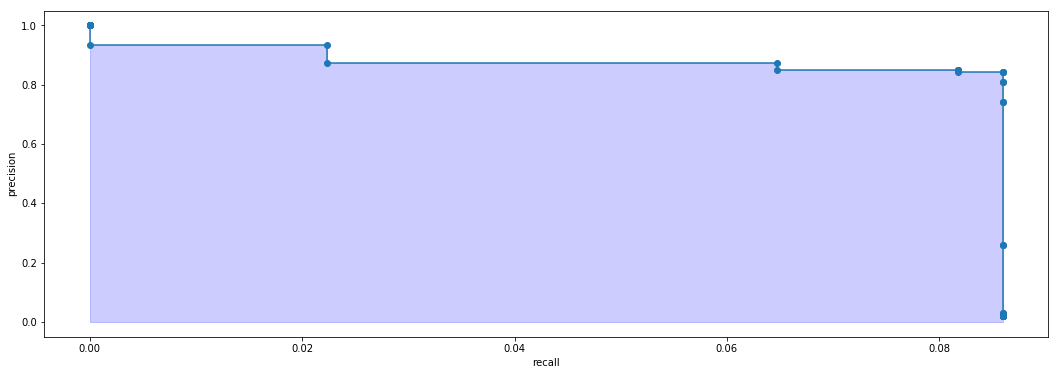

In [46]:
# plt.plot(recall,precision, '-o')
fig, axes = plt.subplots(1,1,figsize=(18,6))
axes.step(recall,precision,'-o',where='post')
axes.fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes.set_xlabel('recall')
axes.set_ylabel('precision')

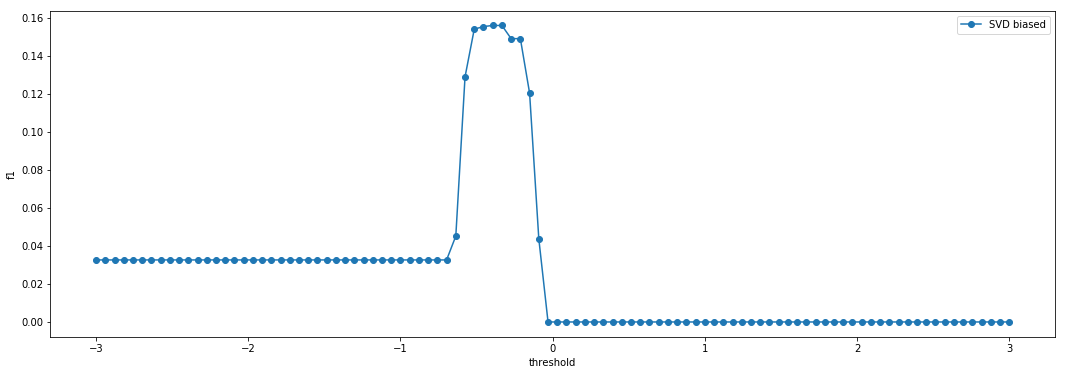

In [47]:
fig, axes = plt.subplots(1,1,figsize=(18,6))
axes.plot(thresholds,f1,'-o', label='SVD biased')
axes.set_xlabel('threshold')
axes.set_ylabel('f1')
axes.legend()